<a href="https://colab.research.google.com/github/filipe-research/tutorial_noisylabels/blob/main/codes/tutorial_sibgrapi20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: How to train your model when you cannot trust onthe annotations? - SIGBRAPI 2020

Authors: Filipe Cordeiro, Gustavo Carneiro

DATASET: 
"MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike."

[Read more.](https://www.kaggle.com/c/digit-recognizer)


<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

In [3]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import random

In [5]:
#@title Define Hyperparameters
# Define Hyperparameters

training_size= 5000
num_epochs = 40 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-3 # size of step
seed=123

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [6]:
##@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))

In [7]:
# Reduce training size  (just for fast training during the tutorial)
train_data.data = train_data.data[:training_size]
train_data.targets = train_data.targets[:training_size]

In [9]:
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True,num_workers=4,pin_memory=True)

eval_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = False,num_workers=4,pin_memory=True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False,num_workers=4)

In [1]:
examples = enumerate(test_gen)

NameError: ignored

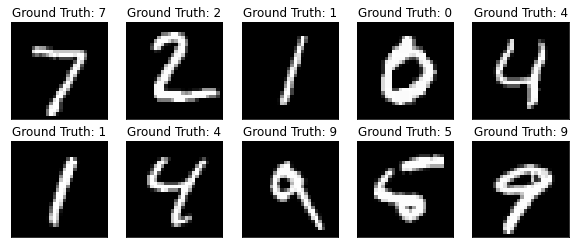

In [11]:
import matplotlib.pyplot as plt

examples = enumerate(test_gen)
batch_idx, (example_data, example_targets) = next(examples)

# fig = plt.figure()
fig = plt.figure(figsize=(10,4))
for i in range(10):
  plt.subplot(2,5,i+1)
  # plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
# fig

In [ ]:
#@title CNN Arquitecture
#CNN Architecture
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # return F.log_softmax(x)
        return(x)

In [13]:
## @title Build the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net = Net(input_size, hidden_size, num_classes)
 
ce_loss = nn.CrossEntropyLoss().to(device)

In [14]:
def test(net, loss_function):
  net.eval()
  test_loss = 0
  correct = 0
  
  with torch.no_grad():
    for data, target in test_gen:
      data, target = data.to(device), target.to(device)
      output = net(data)
      # test_loss += F.nll_loss(output, target, size_average=False).item()
      # test_loss += loss_function(output, target, size_average=False).item()
      test_loss += loss_function(output, target)
      # pred = output.data.max(1, keepdim=True)[1]
      _, pred = torch.max(output, 1)  
      # correct += pred.eq(target.data.view_as(pred)).sum()
      correct += pred.eq(target).cpu().sum().item() 
  acc = 100.*correct/len(test_gen.dataset)
  test_loss /= len(test_gen)
  
  # test_losses.append(test_loss)
  # print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  #   test_loss, correct, len(test_loader.dataset),
  #   100. * correct / len(test_loader.dataset)))
  return acc, test_loss

In [15]:
#@title evaluate model
from sklearn.mixture import GaussianMixture

def eval(net):
  net.eval()
  
  losses = torch.zeros(len(eval_gen.dataset))    
  CE = nn.CrossEntropyLoss(reduction='none')
  with torch.no_grad():
    for i ,(images,labels) in enumerate(eval_gen):
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = CE(outputs, labels)
        for b in range(images.size(0)):
          idx = batch_size*i+b
          losses[idx]=loss[b] 
  
  losses = (losses-losses.min())/(losses.max()-losses.min())    
  input_loss = losses.reshape(-1,1)

  # fit a two-component GMM to the loss
  gmm = GaussianMixture(n_components=2,max_iter=50,tol=1e-2,reg_covar=5e-4)
  gmm.fit(input_loss)
  prob = gmm.predict_proba(input_loss) 
  prob = prob[:,gmm.means_.argmin()] 
  return losses, prob



In [16]:
#@title Training the model
def train(loss_function):
  #initialize network
  torch.manual_seed(seed)
  net = Net()
  net = net.to(device)
  optimizer = torch.optim.Adam( net.parameters(), lr=lr) 

  losses_train=[]
  losses_test=[]
  acc_train_log=[]
  acc_test_log=[]
  all_losses=[]

  #for epoch in range(num_epochs):
  for epoch in range(num_epochs):
    train_loss = train_acc = correct = 0
    net.train()
    for i ,(images,labels) in enumerate(train_gen):
      #images = Variable(images.view(-1,28*28)).cuda()
      #images = images.view(-1,28*28).to(device)
      images = images.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = loss_function(outputs, labels)
      train_loss+= loss
      loss.backward()

      optimizer.step()

      _, pred = torch.max(outputs, 1)  
      correct += pred.eq(labels).cpu().sum().item() 
      
      
      if (i+1) % 100 == 0:
        print('Epoch [%d/%d], Step [%d/%d]'
                  %(epoch+1, num_epochs, i+1, len(train_data)//batch_size))
        # print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
        #            %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))
    train_loss/=len(train_gen)
    train_acc=100.*correct/len(train_gen.dataset)

    losses_train.append(train_loss)
    acc_train_log.append(train_acc)

    all_losses.append(eval(net))
    
    acc_test, loss_test=test(net, loss_function)
    losses_test.append(loss_test)
    acc_test_log.append(acc_test)
    print('Epoch [{}/{}],\ttrain loss:{:.4f},\ttrain acc:{:.2f},\ttest loss:{:.4f},\ttest accuracy:{:.2f}'.format(epoch,num_epochs,train_loss,train_acc, loss_test, acc_test))
    #testing
    
  return losses_train, losses_test, acc_train_log, acc_test_log, all_losses


In [155]:
losses_train, losses_test, acc_train_log, acc_test_log,all_loss_idx = train(ce_loss)

Epoch [0/40],	train loss:2.0300,	train acc:27.04,	test loss:1.1910,	test accuracy:74.48
Epoch [1/40],	train loss:1.1672,	train acc:61.38,	test loss:0.4864,	test accuracy:88.99
Epoch [2/40],	train loss:0.8122,	train acc:73.38,	test loss:0.3254,	test accuracy:92.36
Epoch [3/40],	train loss:0.6771,	train acc:78.42,	test loss:0.2579,	test accuracy:93.06
Epoch [4/40],	train loss:0.6019,	train acc:81.80,	test loss:0.2205,	test accuracy:94.06
Epoch [5/40],	train loss:0.5562,	train acc:82.88,	test loss:0.1971,	test accuracy:94.78
Epoch [6/40],	train loss:0.5130,	train acc:84.58,	test loss:0.1814,	test accuracy:95.01
Epoch [7/40],	train loss:0.4801,	train acc:85.12,	test loss:0.1785,	test accuracy:94.84
Epoch [8/40],	train loss:0.4573,	train acc:85.78,	test loss:0.1701,	test accuracy:95.11
Epoch [9/40],	train loss:0.4433,	train acc:86.42,	test loss:0.1554,	test accuracy:95.69
Epoch [10/40],	train loss:0.4369,	train acc:86.34,	test loss:0.1529,	test accuracy:95.66
Epoch [11/40],	train loss:0.401

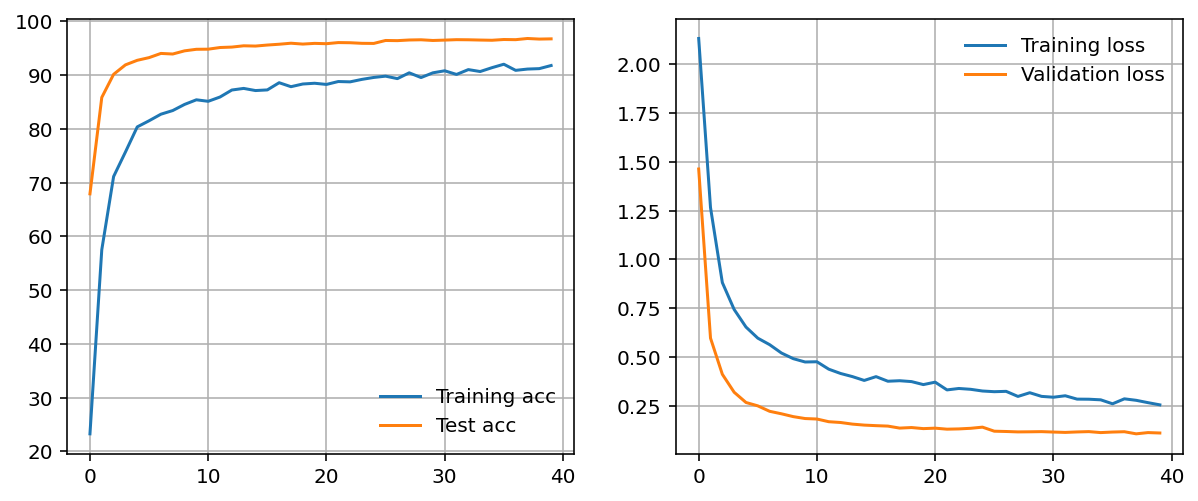

In [14]:
import matplotlib.pyplot as plt # for plotting beautiful graphs
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(acc_train_log, label='Training acc')
plt.plot(acc_test_log, label='Test acc')
plt.legend(frameon=False)
plt.grid()

plt.subplot(1,2,2)
plt.plot(losses_train, label='Training loss')
plt.plot(losses_test, label='Validation loss')
plt.legend(frameon=False)
plt.grid()


## Generate Noisy MNIST

Build synthetic noise benchmark on MNIST

In [17]:
gt_labels = train_data.targets   #ground truth labels (clean)

In [18]:
gt_labels.shape

torch.Size([5000])

In [19]:
##generate noise
import random

transition = {0:0,2:0,4:7,7:7,1:1,9:1,3:5,5:3,6:6,8:8} # class transition for asymmetric noise

def generate_noise(nr, gt_labels, noise_mode='sym'):
  noise_label = []
  idx = list(range(len(gt_labels)))
  random.shuffle(idx)
  num_noise = int(nr*len(gt_labels))            
  noise_idx = idx[:num_noise]
  for i in range(len(gt_labels)):
      if i in noise_idx:
        if noise_mode=='sym':
          noiselabel = random.randint(0,9)  
          noise_label.append(noiselabel)
        elif noise_mode=='asym':   
          noiselabel = transition[gt_labels[i].item()]
          noise_label.append(noiselabel)                    
      else:    
        noise_label.append(gt_labels[i])  
  return torch.tensor(noise_label)


In [20]:
noisy_labels = generate_noise(0.7, gt_labels, 'sym')

print('real noise rate:{:.2f}'.format((np.array(noisy_labels)!=np.array(gt_labels)).sum()/len(gt_labels)))

real noise rate:0.63


In [20]:
noisy_map = np.zeros((10, 10))
for i in range(len(gt_labels)):
  noisy_map[int(noisy_labels[i])][int(gt_labels[i])] += 1

  #calculate de percentage. Divides each element by the sum of the row
  percent_map = noisy_map/noisy_map.sum(axis=0, keepdims=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 33.0, 'true labels')

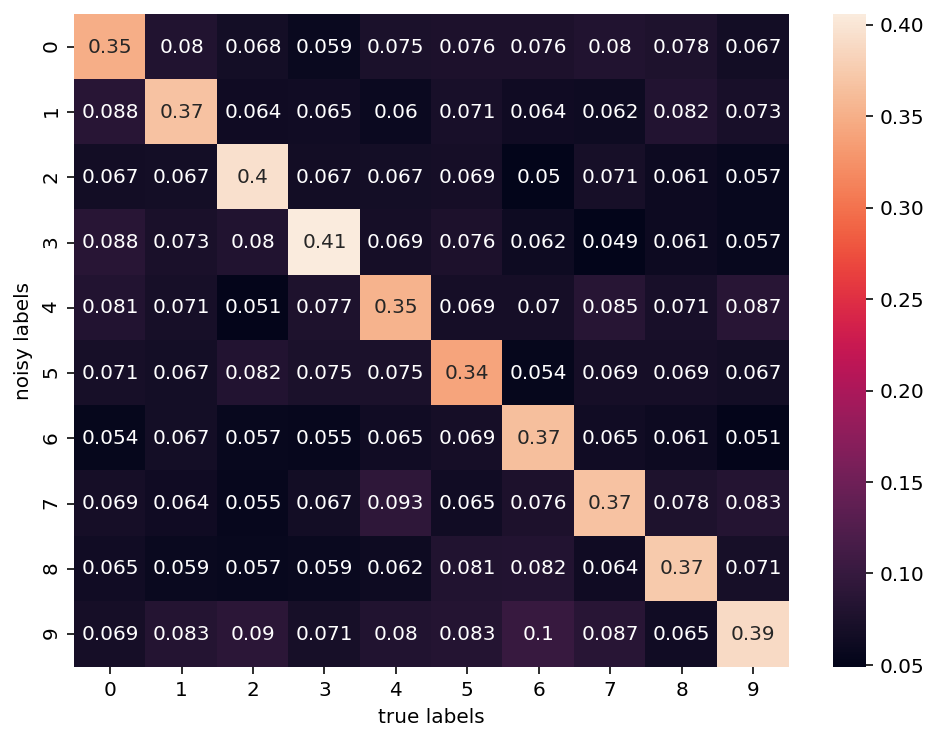

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(percent_map, index = [0,1,2,3,4,5,6,7,8,9],
                  columns = list(range(10)))
plt.figure(figsize = (8,6))

sn.heatmap(df_cm, annot=True)
plt.ylabel('noisy labels')
plt.xlabel('true labels')


p(nl=2|tl=2) = 0.4\
p(nl=2|tl=3) = 0.077


In [ ]:
p(nl=2|tl=)

0.07

In [ ]:
unique_elements, counts_elements = np.unique(noisy_labels, return_counts=True)
# unique_elements, counts_elements = np.unique(gt_labels, return_counts=True)

In [ ]:
unique_elements

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<BarContainer object of 10 artists>

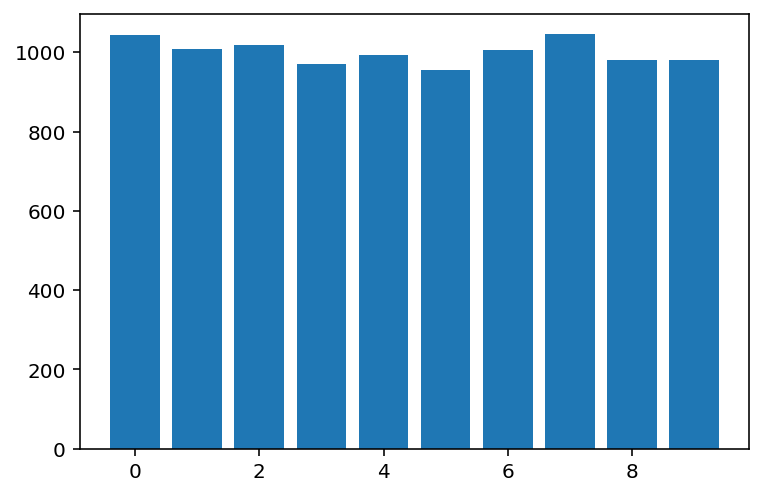

In [ ]:
plt.bar(unique_elements,counts_elements)

In [ ]:
0.7*5000*0.9/5000

0.63

In [21]:
noisy_labels70 = generate_noise(0.7, gt_labels, 'sym')
print('real noise rate:{:.2f}'.format((np.array(noisy_labels70)!=np.array(gt_labels)).sum()/len(gt_labels)))


real noise rate:0.63


In [84]:
#train with 30% noise rate
noisy_labels = generate_noise(0.3, gt_labels, 'sym')
print('real noise rate:{:.2f}'.format((np.array(noisy_labels)!=np.array(gt_labels)).sum()/len(gt_labels)))
train_data.targets = noisy_labels  #update current labels
losses_train30, losses_test30, acc_train_log30, acc_test_log30, all_loss_idx_30 = train(ce_loss)

real noise rate:0.27
Epoch [0/10],	train loss:2.0736,	train acc:29.40,	test loss:1.1126,	test accuracy:83.34
Epoch [1/10],	train loss:1.6961,	train acc:54.63,	test loss:0.8243,	test accuracy:90.76
Epoch [2/10],	train loss:1.6140,	train acc:59.85,	test loss:0.7075,	test accuracy:93.07
Epoch [3/10],	train loss:1.5695,	train acc:62.47,	test loss:0.6951,	test accuracy:93.96
Epoch [4/10],	train loss:1.5332,	train acc:63.59,	test loss:0.7137,	test accuracy:94.79
Epoch [5/10],	train loss:1.5183,	train acc:64.31,	test loss:0.6057,	test accuracy:94.91
Epoch [6/10],	train loss:1.5148,	train acc:64.77,	test loss:0.5801,	test accuracy:95.31
Epoch [7/10],	train loss:1.4963,	train acc:65.27,	test loss:0.5670,	test accuracy:95.67
Epoch [8/10],	train loss:1.4935,	train acc:65.99,	test loss:0.5692,	test accuracy:95.95
Epoch [9/10],	train loss:1.4843,	train acc:66.06,	test loss:0.5115,	test accuracy:96.05


In [158]:
#train with 70% noise rate
#noisy_labels = generate_noise(0.7, gt_labels, 'sym')
train_data.targets = noisy_labels70  #update current labels
losses_train70, losses_test70, acc_train_log70, acc_test_log70, all_loss_idx = train(ce_loss)

Epoch [0/40],	train loss:2.3004,	train acc:11.16,	test loss:2.2241,	test accuracy:34.94
Epoch [1/40],	train loss:2.2693,	train acc:16.38,	test loss:2.0376,	test accuracy:63.27
Epoch [2/40],	train loss:2.2395,	train acc:19.56,	test loss:1.8858,	test accuracy:76.37
Epoch [3/40],	train loss:2.2158,	train acc:22.58,	test loss:1.8213,	test accuracy:80.48
Epoch [4/40],	train loss:2.1984,	train acc:24.62,	test loss:1.7641,	test accuracy:84.23
Epoch [5/40],	train loss:2.1926,	train acc:25.50,	test loss:1.7135,	test accuracy:86.21
Epoch [6/40],	train loss:2.1841,	train acc:26.12,	test loss:1.6886,	test accuracy:85.47
Epoch [7/40],	train loss:2.1792,	train acc:26.94,	test loss:1.5963,	test accuracy:89.03
Epoch [8/40],	train loss:2.1586,	train acc:28.40,	test loss:1.6225,	test accuracy:88.16
Epoch [9/40],	train loss:2.1587,	train acc:28.66,	test loss:1.6855,	test accuracy:88.77
Epoch [10/40],	train loss:2.1558,	train acc:28.76,	test loss:1.6226,	test accuracy:89.69
Epoch [11/40],	train loss:2.156

In [ ]:
#train with 40% asymm noise
noisy_labels = generate_noise(0.4, gt_labels, 'asym')
train_data.targets = noisy_labels  #update current labels
losses_train40, losses_test40, acc_train_log40, acc_test_log40 = train()

Epoch [0/10],	train loss:1.3407,	train acc:50.67,	test loss:0.5603,	test accuracy:79.61
Epoch [1/10],	train loss:0.8090,	train acc:66.92,	test loss:0.4384,	test accuracy:86.07
Epoch [2/10],	train loss:0.7301,	train acc:68.73,	test loss:0.4480,	test accuracy:78.24
Epoch [3/10],	train loss:0.6774,	train acc:69.42,	test loss:0.3909,	test accuracy:87.22
Epoch [4/10],	train loss:0.6494,	train acc:70.58,	test loss:0.4187,	test accuracy:82.60
Epoch [5/10],	train loss:0.6228,	train acc:71.38,	test loss:0.3797,	test accuracy:86.62
Epoch [6/10],	train loss:0.6262,	train acc:70.57,	test loss:0.3793,	test accuracy:88.13
Epoch [7/10],	train loss:0.6023,	train acc:71.21,	test loss:0.3752,	test accuracy:88.42
Epoch [8/10],	train loss:0.6069,	train acc:71.49,	test loss:0.3747,	test accuracy:89.36
Epoch [9/10],	train loss:0.5797,	train acc:72.01,	test loss:0.3687,	test accuracy:83.97


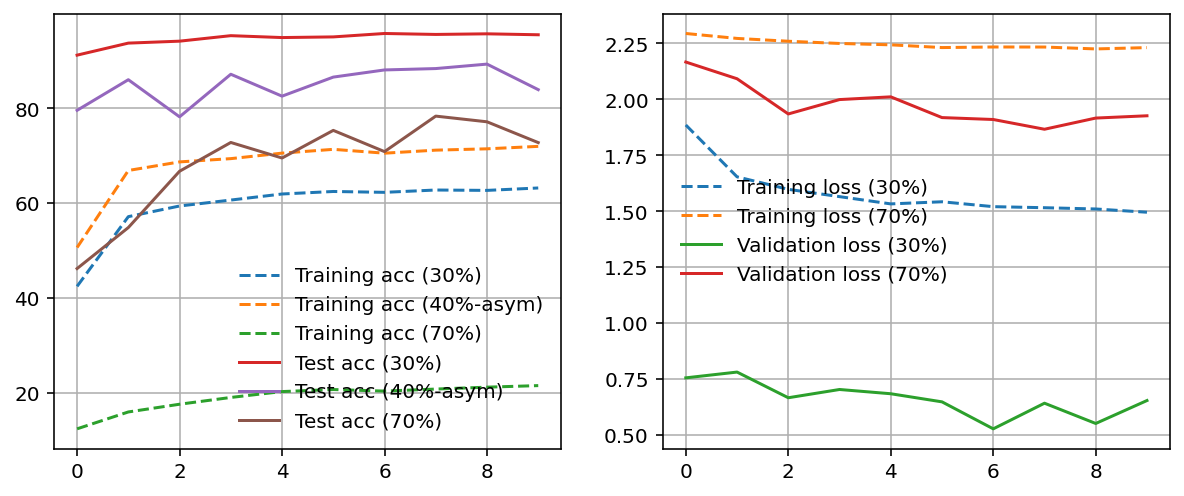

In [ ]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(acc_train_log30, label='Training acc (30%)',linestyle='--')
plt.plot(acc_train_log40, label='Training acc (40%-asym)',linestyle='--')
plt.plot(acc_train_log70, label='Training acc (70%)',linestyle='--')
plt.plot(acc_test_log30, label='Test acc (30%)')
plt.plot(acc_test_log40, label='Test acc (40%-asym)')
plt.plot(acc_test_log70, label='Test acc (70%)')
plt.legend(frameon=False)
plt.grid()

plt.subplot(1,2,2)
plt.plot(losses_train30, label='Training loss (30%)',linestyle='--')
plt.plot(losses_train70, label='Training loss (70%)',linestyle='--')
plt.plot(losses_test30, label='Validation loss (30%)')
plt.plot(losses_test70, label='Validation loss (70%)')
plt.legend(frameon=False)
plt.grid()

In [ ]:
#show distribution noisy samples x clean samples
# show avg loss os clean and noisy samples

## Train Noisy MNIST

Ideias:
- Treinar NOISY: mostrar resultados piores (ok)
- mostrar comportamento do ruído (transition matrix (ok), clean vs noisy loss, tsne-plot)
- Mostrar que existe uma certa diferenta entre ruido e clean
Solucoes:
 - Boostrap ou Loss Simples (mostrar melhoria)
 - GMM + Remover as amostras (mostrar melhoria)
 - GMM + Mixup (mostrar melhoria)
 

## Combating Noisy Labels

### Robust Loss

In [ ]:
#Active Passive Loss (ICML 2020)
#paper code: https://github.com/HanxunH/Active-Passive-Losses

In [37]:
class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes=10, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        # label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float()
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()

In [38]:
class ReverseCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(ReverseCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))
        return self.scale * rce.mean()

In [39]:
class NCEandRCE(torch.nn.Module):
    def __init__(self, alpha=0.1, beta=1, num_classes=10):
        super(NCEandRCE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.rce(pred, labels)

In [40]:
class NormalizedFocalLoss(torch.nn.Module):
    def __init__(self, scale=1.0, gamma=0, num_classes=10, alpha=None, size_average=True):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma
        self.size_average = size_average
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, input, target):
        target = target.view(-1, 1)
        logpt = F.log_softmax(input, dim=1)
        normalizor = torch.sum(-1 * (1 - logpt.data.exp()) ** self.gamma * logpt, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = torch.autograd.Variable(logpt.data.exp())
        loss = -1 * (1-pt)**self.gamma * logpt
        loss = self.scale * loss / normalizor

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [41]:
class NFLandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10, gamma=0.5):
        super(NFLandRCE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.rce(pred, labels)

In [42]:
class MeanAbsoluteError(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale
        return

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        mae = 1. - torch.sum(label_one_hot * pred, dim=1)
        # Note: Reduced MAE
        # Original: torch.abs(pred - label_one_hot).sum(dim=1)
        # $MAE = \sum_{k=1}^{K} |\bm{p}(k|\bm{x}) - \bm{q}(k|\bm{x})|$
        # $MAE = \sum_{k=1}^{K}\bm{p}(k|\bm{x}) - p(y|\bm{x}) + (1 - p(y|\bm{x}))$
        # $MAE = 2 - 2p(y|\bm{x})$
        #
        return self.scale * mae.mean()

In [43]:
class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)

In [159]:
#train with 70% noise rate
# noisy_labels = generate_noise(0.7, gt_labels, 'sym')
train_data.targets = noisy_labels70  #update current labels
# criterion = NCEandRCE(alpha=1, beta=0.1)
criterion =NCEandMAE(alpha=1, beta=1)
# criterion = NFLandRCE(alpha=1, beta=100)
losses_train70_APL, losses_test70_APL, acc_train_log70_APL, acc_test_log70_APL, all_loss_idx_APL = train(criterion)

Epoch [0/40],	train loss:0.9973,	train acc:11.24,	test loss:0.9564,	test accuracy:25.79
Epoch [1/40],	train loss:0.9581,	train acc:14.70,	test loss:0.6695,	test accuracy:40.75
Epoch [2/40],	train loss:0.9096,	train acc:18.82,	test loss:0.4863,	test accuracy:60.84
Epoch [3/40],	train loss:0.8765,	train acc:21.38,	test loss:0.4435,	test accuracy:61.16
Epoch [4/40],	train loss:0.8599,	train acc:22.54,	test loss:0.3711,	test accuracy:67.38
Epoch [5/40],	train loss:0.8466,	train acc:23.82,	test loss:0.3280,	test accuracy:69.94
Epoch [6/40],	train loss:0.8437,	train acc:24.04,	test loss:0.3211,	test accuracy:69.61
Epoch [7/40],	train loss:0.8280,	train acc:25.78,	test loss:0.1977,	test accuracy:84.01
Epoch [8/40],	train loss:0.8103,	train acc:27.20,	test loss:0.1820,	test accuracy:84.57
Epoch [9/40],	train loss:0.8036,	train acc:27.62,	test loss:0.1657,	test accuracy:86.15
Epoch [10/40],	train loss:0.8008,	train acc:27.64,	test loss:0.1315,	test accuracy:89.11
Epoch [11/40],	train loss:0.796

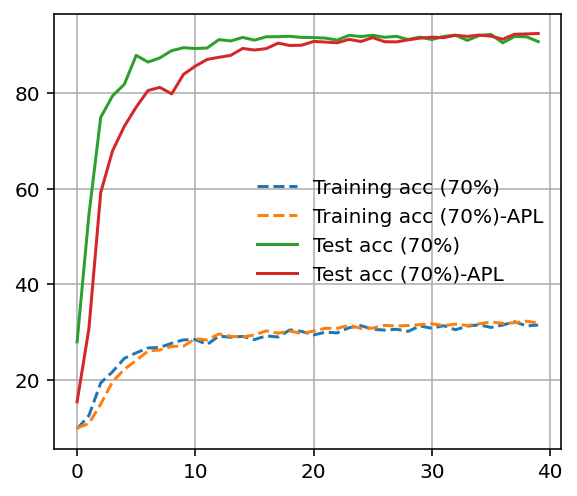

In [32]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# plt.plot(acc_train_log30, label='Training acc (30%)',linestyle='--')
# plt.plot(acc_train_log40, label='Training acc (40%-asym)',linestyle='--')
plt.plot(acc_train_log70, label='Training acc (70%)',linestyle='--')
plt.plot(acc_train_log70_APL, label='Training acc (70%)-APL',linestyle='--')
# plt.plot(acc_test_log30, label='Test acc (30%)')
# plt.plot(acc_test_log40, label='Test acc (40%-asym)')
plt.plot(acc_test_log70, label='Test acc (70%)')
plt.plot(acc_test_log70_APL, label='Test acc (70%)-APL')
plt.legend(frameon=False)
plt.grid()

### small-loss trick

- histogram clean/noisy
- avg mean clean/noisy
- remove noisy

In [ ]:
len(all_loss_idx[0])

10000

In [ ]:
inds_noisy = np.asarray([ind for ind in range(len(noisy_labels)) if noisy_labels[ind] != gt_labels[ind]])
inds_clean = np.delete(np.arange(len(noisy_labels)), inds_noisy)


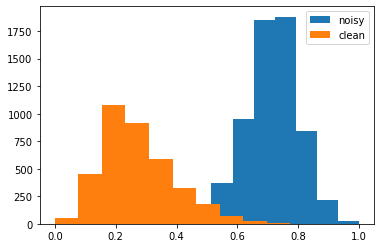

In [ ]:
plt.hist(all_loss_idx[-1][inds_noisy],label='noisy')
plt.hist(all_loss_idx[-1][inds_clean],label='clean')
plt.legend()

In [ ]:
# avg_loss_clean=[]
# avg_loss_noisy=[]
# for i in range(num_epochs):
#   loss_clean = all_loss_idx_30[1][inds_clean]
avg_loss_clean = [all_loss_idx_30[i][inds_clean].mean() for i in range(num_epochs)]
avg_loss_noisy = [all_loss_idx_30[i][inds_noisy].mean() for i in range(num_epochs)]

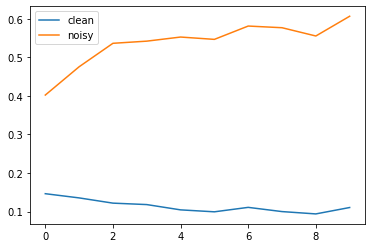

In [ ]:
plt.plot(avg_loss_clean, label='clean')
plt.plot(avg_loss_noisy, label='noisy')
plt.legend()

In [ ]:
#Filter noisy samples, using GMM

In [34]:
#@title Training the model filter
import os
from torch.utils.data import Subset
CE = nn.CrossEntropyLoss(reduction='none')
def train_filtering(loss_function):
  
  
  # os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
  #initialize network
  torch.manual_seed(seed)
  net = Net()
  net = net.to(device)
  optimizer = torch.optim.Adam( net.parameters(), lr=lr) 

  losses_train=[]
  losses_test=[]
  acc_train_log=[]
  acc_test_log=[]
  all_losses=[]

  clean_gen = train_gen
  
  #for epoch in range(num_epochs):
  
  for epoch in range(num_epochs):
    train_loss = train_acc = correct = 0
    net.train()
    count=0
    for i ,(images,labels) in enumerate(clean_gen):
      count+=images.size(0)
      #images = Variable(images.view(-1,28*28)).cuda()
      #images = images.view(-1,28*28).to(device)
      images = images.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = loss_function(outputs, labels)
      # if epoch>0:
      #   print('enter')
      #   loss = CE(outputs, labels)
      #   loss = loss[idx_pred_c].mean()
      train_loss+= loss
      loss.backward()

      optimizer.step()

      _, pred = torch.max(outputs, 1)  
      correct += pred.eq(labels).cpu().sum().item() 
      
      
      # if (i+1) % 100 == 0:
      #   print('Epoch [%d/%d], Step [%d/%d]'
      #             %(epoch+1, num_epochs, i+1, len(train_data)//batch_size))
        # print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
        #            %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))
    print(count)
    train_loss/=len(clean_gen)
    train_acc=100.*correct/len(clean_gen.dataset)

    losses_train.append(train_loss)
    acc_train_log.append(train_acc)

    # all_losses.append(eval(net))
    losses, prob = eval(net)
    all_losses.append(losses)

    if epoch>15:
      pred_idx_clean = (prob > 0.5).nonzero()[0]
      
      train_clean = Subset(train_data, pred_idx_clean)
      # clean_dataset.data = train_data.data[inds_clean]
      clean_gen = torch.utils.data.DataLoader(train_clean,
                                              batch_size = batch_size,
                                              shuffle = True,num_workers=8,pin_memory=True)

    # import pdb;pdb.set_trace()
    # idx_pred_c = (noisy_labels==gt_labels).nonzero()[0]
    # idx_pred_c = inds_clean
    # import pdb; pdb.set_trace()
    acc_test, loss_test=test(net, loss_function)
    losses_test.append(loss_test)
    acc_test_log.append(acc_test)
    print('Epoch [{}/{}],\ttrain loss:{:.4f},\ttrain acc:{:.2f},\ttest loss:{:.4f},\ttest accuracy:{:.2f}'.format(epoch,num_epochs,train_loss,train_acc, loss_test, acc_test))
    #testing
    
  return losses_train, losses_test, acc_train_log, acc_test_log, all_losses


In [35]:
# noisy_labels = generate_noise(0.3, gt_labels, 'sym')
inds_noisy = np.asarray([ind for ind in range(len(noisy_labels70)) if noisy_labels70[ind] != gt_labels[ind]])
inds_clean = np.delete(np.arange(len(noisy_labels70)), inds_noisy)
train_data.targets = noisy_labels70  #update current labels
losses_train70_F, losses_test70_F, acc_train_log70_F, acc_test_log70_F, all_loss_idx_F = train_filtering(ce_loss)

5000
Epoch [0/40],	train loss:2.3058,	train acc:10.48,	test loss:2.2692,	test accuracy:30.47
5000
Epoch [1/40],	train loss:2.2850,	train acc:13.88,	test loss:2.1317,	test accuracy:61.17
5000
Epoch [2/40],	train loss:2.2527,	train acc:18.74,	test loss:1.9475,	test accuracy:73.01
5000
Epoch [3/40],	train loss:2.2281,	train acc:22.16,	test loss:1.8437,	test accuracy:78.74
5000
Epoch [4/40],	train loss:2.2111,	train acc:24.12,	test loss:1.8071,	test accuracy:82.84
5000
Epoch [5/40],	train loss:2.2029,	train acc:25.34,	test loss:1.7705,	test accuracy:87.79
5000
Epoch [6/40],	train loss:2.1939,	train acc:26.04,	test loss:1.7764,	test accuracy:87.02
5000
Epoch [7/40],	train loss:2.1872,	train acc:27.12,	test loss:1.6801,	test accuracy:87.75
5000
Epoch [8/40],	train loss:2.1764,	train acc:27.72,	test loss:1.6741,	test accuracy:89.26
5000
Epoch [9/40],	train loss:2.1829,	train acc:28.02,	test loss:1.7014,	test accuracy:88.47
5000
Epoch [10/40],	train loss:2.1782,	train acc:27.84,	test loss:1.61

In [ ]:
criterion =NCEandMAE(alpha=1, beta=10)
train_data.targets = noisy_labels70  #update current labels
losses_train70_F, losses_test70_F, acc_train_log70_F, acc_test_log70_F, all_loss_idx_F = train_filtering(criterion)

### gmm + data augm (mixup)

In [31]:
#@title Training the model filter
import os
from torch.utils.data import Subset
CE = nn.CrossEntropyLoss(reduction='none')
def train_mixup(loss_function):
  
  
  # os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
  #initialize network
  torch.manual_seed(seed)
  net = Net()
  net = net.to(device)
  optimizer = torch.optim.Adam( net.parameters(), lr=lr) 

  losses_train=[]
  losses_test=[]
  acc_train_log=[]
  acc_test_log=[]
  all_losses=[]

  
  clean_gen = train_gen
  #for epoch in range(num_epochs):
  wm=15
  for epoch in range(num_epochs):
    train_loss = train_acc = correct = 0
    net.train()
    count=0
    if epoch>wm:
      unlabeled_train_iter = iter(noisy_gen) 
    
    for i ,(images,targets_x) in enumerate(clean_gen):
      count+=images.size(0)
      #images = Variable(images.view(-1,28*28)).cuda()
      #images = images.view(-1,28*28).to(device)
      inputs_x = images.to(device)

      targets_x = torch.zeros(images.size(0), 10).scatter_(1, targets_x.view(-1,1), 1)
      targets_x = targets_x.to(device)
      # targets_x = labels.to(device)

      optimizer.zero_grad()
      outputs = net(inputs_x)
      
      if epoch<=wm:
        # loss = loss_function(outputs, targets_x)
        outputs = net(inputs_x) 
        loss = -torch.mean(torch.sum(F.log_softmax(outputs, dim=1) * targets_x, dim=1))
      else:

        try:
          inputs_u, _ = unlabeled_train_iter.next()
        except:
          unlabeled_train_iter = iter(noisy_gen)
          inputs_u, _ = unlabeled_train_iter.next()  
        inputs_u = inputs_u.to(device)

        with torch.no_grad():
          outputs_u = net(inputs_u)
          pu = torch.softmax(outputs_u, dim=1)
          ptu = pu**(1/0.5) # temparature sharpening
          targets_u = ptu / ptu.sum(dim=1, keepdim=True) # normalize
          # targets_u=ptu
        # targets_u = targets_u.detach()

        # join_input = torch.cat([inputs_x, inputs_u], dim=0)
        # join_outputs = net(join_input)  
        # outputs= join_outputs[:batch_size]
        # outputs_u= join_outputs[batch_size:]
        # pu = torch.softmax(outputs_u, dim=1)

        # mixmatch
        l = np.random.beta(4, 4)        
        l = max(l, 1-l)

        all_inputs = torch.cat([inputs_x,inputs_x, inputs_u,inputs_u ], dim=0)
        # print(inputs_x.size(0),inputs_u.size(0))
        # print(targets_x.shape,targets_u.shape)
        # print(targets_x)
        # print(targets_u)
        all_targets = torch.cat([targets_x,targets_x, targets_u,targets_u], dim=0)

        idx = torch.randperm(all_inputs.size(0))

        input_a, input_b = all_inputs, all_inputs[idx]
        target_a, target_b = all_targets, all_targets[idx]
              
        mixed_input = l * input_a + (1 - l) * input_b        
        mixed_target = l * target_a + (1 - l) * target_b
                      
        logits = net(mixed_input)
        logits_x = logits[:batch_size*2]
        logits_u = logits[batch_size*2:] 

        target_x = mixed_target[:batch_size*2]
        # target_x = targets_x
        # targets_u= mixed_target[batch_size:]

        # probs_u = torch.softmax(logits_u, dim=1)
        Lx = -torch.mean(torch.sum(F.log_softmax(logits_x, dim=1) * mixed_target[:batch_size*2], dim=1))
        # Lx = -torch.mean(torch.sum(F.log_softmax(outputs, dim=1) * target_x, dim=1))
        #Lu = torch.mean((probs_u - targets_u)**2) 
        Lu = -torch.mean(torch.sum(pu.log()*pu, dim=1)) #entropy
        
        
        #loss = loss_function(outputs, labels)
        loss = Lx + 0*Lu
      # if epoch>0:
      #   print('enter')
      #   loss = CE(outputs, labels)
      #   loss = loss[idx_pred_c].mean()
      train_loss+= loss
      loss.backward()

      optimizer.step()

      _, pred = torch.max(outputs, 1)  
      # correct += pred.eq(targets_x).cpu().sum().item() 
      correct = 0
      
    print(count)
    train_loss/=len(clean_gen)
    train_acc=100.*correct/len(clean_gen.dataset)

    losses_train.append(train_loss)
    acc_train_log.append(train_acc)

    # all_losses.append(eval(net))
    losses, prob = eval(net)
    all_losses.append(losses)

    if epoch>=wm:
      pred_idx_clean = (prob > 0.5).nonzero()[0]
      pred_idx_noisy = (prob <= 0.5).nonzero()[0]
      
      train_clean = Subset(train_data, pred_idx_clean)
      train_noisy = Subset(train_data, pred_idx_noisy)
      # clean_dataset.data = train_data.data[inds_clean]
      clean_gen = torch.utils.data.DataLoader(train_clean,
                                              batch_size = batch_size, drop_last=True,
                                              shuffle = True,num_workers=8,pin_memory=True)
      noisy_gen = torch.utils.data.DataLoader(train_noisy,
                                              batch_size = batch_size, drop_last=True,
                                              shuffle = True,num_workers=8,pin_memory=True)

    # import pdb;pdb.set_trace()
    # idx_pred_c = (noisy_labels==gt_labels).nonzero()[0]
    # idx_pred_c = inds_clean
    # import pdb; pdb.set_trace()
    acc_test, loss_test=test(net, loss_function)
    losses_test.append(loss_test)
    acc_test_log.append(acc_test)
    print('Epoch [{}/{}],\ttrain loss:{:.4f},\ttrain acc:{:.2f},\ttest loss:{:.4f},\ttest accuracy:{:.2f}'.format(epoch,num_epochs,train_loss,train_acc, loss_test, acc_test))
    #testing
    
  return losses_train, losses_test, acc_train_log, acc_test_log, all_losses


In [32]:
train_data.targets = noisy_labels70  #update current labels
losses_train70_F, losses_test70_F, acc_train_log70_F, acc_test_log70_F, all_loss_idx_F = train_mixup(ce_loss)

5000
Epoch [0/40],	train loss:2.3040,	train acc:0.00,	test loss:2.2522,	test accuracy:36.06
5000
Epoch [1/40],	train loss:2.2816,	train acc:0.00,	test loss:2.1325,	test accuracy:62.85
5000
Epoch [2/40],	train loss:2.2465,	train acc:0.00,	test loss:1.9351,	test accuracy:80.39
5000
Epoch [3/40],	train loss:2.2220,	train acc:0.00,	test loss:1.8751,	test accuracy:72.05
5000
Epoch [4/40],	train loss:2.2116,	train acc:0.00,	test loss:1.7440,	test accuracy:81.66
5000
Epoch [5/40],	train loss:2.2020,	train acc:0.00,	test loss:1.7534,	test accuracy:87.61
5000
Epoch [6/40],	train loss:2.1998,	train acc:0.00,	test loss:1.7678,	test accuracy:89.82
5000
Epoch [7/40],	train loss:2.1870,	train acc:0.00,	test loss:1.7170,	test accuracy:89.44
5000
Epoch [8/40],	train loss:2.1821,	train acc:0.00,	test loss:1.6566,	test accuracy:90.28
5000
Epoch [9/40],	train loss:2.1767,	train acc:0.00,	test loss:1.6417,	test accuracy:90.29
5000
Epoch [10/40],	train loss:2.1574,	train acc:0.00,	test loss:1.5970,	test ac